# **Structured Output Pattern with LangGraph Agents:**

A Structured Output Agent in LangChain (or other LLM frameworks) refers to an agent that <u>**produces responses in a specific structured format, such as JSON, dictionaries, or other structured data types**</u>. <br>

These agents are particularly useful when you want to ensure that your responses conform to a defined schema, making it easier to parse, validate, and utilize in downstream applications.

<br>

**Why Use a Structured Output?**

* **Controlled Responses:** Ensures that the outputs follow a specific format, reducing ambiguity.
* **Data Validation:** Useful when you want the model output to fit predefined structures, like for APIs or database entries.
* **Automation:** Makes integration with systems like dashboards, ETL pipelines, or business workflows easier.

In [2]:
import os
from dotenv import load_dotenv

# Load environment variables from .env file
load_dotenv()

GOOGLE_API_KEY = os.getenv("GOOGLE_API_KEY")
GROQ_API_KEY = os.getenv("GROQ_API_KEY")
TAVILY_API_KEY = os.getenv("TAVILY_API_KEY")

## **Experiment 01:**

### **Load LLM:**

In [4]:
from langchain_groq import ChatGroq


# Initialize the model
llm = ChatGroq(model_name="Gemma2-9b-It")

llm.invoke("Hi")

AIMessage(content='Hi there! 👋 \n\nHow can I help you today?\n', additional_kwargs={}, response_metadata={'token_usage': {'completion_tokens': 16, 'prompt_tokens': 11, 'total_tokens': 27, 'completion_time': 0.029090909, 'prompt_time': 0.001958696, 'queue_time': 0.018192602000000002, 'total_time': 0.031049605}, 'model_name': 'Gemma2-9b-It', 'system_fingerprint': 'fp_10c08bf97d', 'finish_reason': 'stop', 'logprobs': None}, id='run-17ed0c88-01d6-403d-a7f5-7159f3fcc293-0', usage_metadata={'input_tokens': 11, 'output_tokens': 16, 'total_tokens': 27})

### **Load Tool:**

* Load `Tavily Tool`,
* Create Custom Tool using `Tavily Tool`,
* Bind the custom tool with `llm`

In [5]:
from langchain_community.tools.tavily_search import TavilySearchResults
from langchain_core.tools import tool

In [6]:
# Tavily Tool:

tavily_tool = TavilySearchResults()

In [8]:
# Build my custm tool using Talvily Tool:

@tool
def get_city_details(prompt):
    "Should do a web search to find the required city details"
    response = tavily_tool.invoke(prompt)
    return response


get_city_details("City of Siliguri")

[{'url': 'https://www.110cities.com/blog/cities/siliguri/',
  'content': 'Siliguri is a city in the West Bengal state of northern India. Siliguri sits at the intersection of several roads leading to the neighboring countries.'},
 {'url': 'https://en.wikipedia.org/wiki/Siliguri',
  'content': 'The city spans areas of the Darjeeling and Jalpaiguri districts in the Indian state of West Bengal. Known as the "Gateway of Northeast India", Siliguri is'},
 {'url': 'https://www.britannica.com/place/Siliguri',
  'content': 'Siliguri, city, northern West Bengal state, northeastern India. It lies just west of the Mahananda River. Siliguri is the terminus of the roads from'},
 {'url': 'https://www.siligurismc.in/history-of-siliguri.php',
  'content': 'Siliguri is the largest and fastest growing city in North Bengal. The growth rate in decade 1971- 81 was 57.8 % . Considering the rapid growth of the city and'},
 {'url': 'https://www.siligurismc.in/',
  'content': 'Siliguri, the gateway to North-East

In [9]:
# Bind The Tools with LLM:

tools = [get_city_details]

llm_with_tools = llm.bind_tools(tools)

### **Define Structure format of My Response:**

The **BaseModel** class is a core component of Pydantic, which is used extensively in Python applications for **data validation**, **type checking**, and **parsing**. It's particularly useful when working with APIs, web frameworks like FastAPI, and other scenarios where you need to enforce data structure and ensure data integrity.

In [10]:
from pydantic import BaseModel, Field
from langgraph.graph import MessagesState, StateGraph, END
from langgraph.prebuilt import ToolNode
from langchain_core.messages import HumanMessage

In [11]:
# Define the Structure format of my response.
class CityDetails(BaseModel):
    """Respond to the user with this"""
    state_name: str = Field(description="State name of the city")
    state_capital: str = Field(description="State capital of the city")
    country_name: str = Field(description="Country name of the city")
    country_capital: str = Field(description="Country capital of the city")


In [12]:
# Inherit 'messages' key from MessagesState, which is a list of chat messages
class AgentState(MessagesState):
    # Final structured response from the agent
    final_response: CityDetails

In [13]:
# Integrate llm with my Structure Response/Output:

llm_with_structured_output = llm.with_structured_output(CityDetails)

### **LangGraph Integration:**

* **call_model:** directly invoke the **`llm_with_tools`**, and return response (Wheather it is simply llm call or tool calls).
* **should_continue:** checks if the respose call the llm or tool.
* **response:** invoke the **`llm_with_structured_output`** to generate the output in Structure format.

#### **Create Nodes:**

In [14]:
# Create Node: call_model

def call_model(state: AgentState):
    print(f" this is 01 input from call model {state}")
    response = llm_with_tools.invoke(state['messages'])

    print(f"this is 02 response from call model  {response}")

    # We return a list, because this will get added to the existing list
    return {"messages": [response]}


# Create Node: tool_node
tool_node = ToolNode(tools)

In [15]:
# Conditional Node: should_continue
def should_continue(state: AgentState):
    messages = state["messages"]
    last_message = messages[-1]

    # If there is no function call, then we respond to the user
    if not last_message.tool_calls:
        return "respond"
    # Otherwise if there is, we continue with the tool
    else:
        return "continue"
    


# Create Node: respond
def respond(state: AgentState):
    print(f"here is 03 state from respond {state}")
    response = llm_with_structured_output.invoke([HumanMessage(content=state['messages'][-1].content)])
    # We return the final answer
    print(f"this is 04 response from respond{response}")
    return {"final_response": response}

#### **Create or Define LangGraph Workflow:**

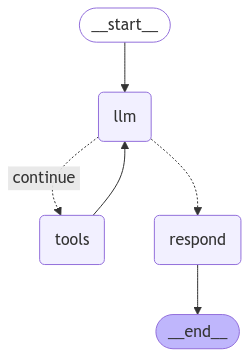

In [16]:
# Define a new graph
workflow = StateGraph(AgentState)

# Add Nodes into Workflow:
workflow.add_node("llm", call_model)
workflow.add_node("tools", tool_node)
workflow.add_node("respond", respond)

# Set the entrypoint:
workflow.set_entry_point("llm")

# This means that this node is the first one called
workflow.add_conditional_edges(
    "llm",
    should_continue,
    {
        "continue": "tools",
        "respond": "respond",
    },
)

# Add Cyclic Node:
workflow.add_edge("tools", "llm")

# Set the exitpoint or end point:
workflow.add_edge("respond", END)

# Compile the Graph:
app = workflow.compile()

app

#### **Invokeing:**

In [17]:
answer = app.invoke(input={"messages": [("human", "Tell me about the city details for Siligur?")]})
answer

 this is 01 input from call model {'messages': [HumanMessage(content='Tell me about the city details for Siligur?', additional_kwargs={}, response_metadata={}, id='7cfa913f-f67c-4036-97a8-af3ec9811a03')]}
this is 02 response from call model  content='' additional_kwargs={'tool_calls': [{'id': 'call_ynjb', 'function': {'arguments': '{"prompt":"Siligur"}', 'name': 'get_city_details'}, 'type': 'function'}]} response_metadata={'token_usage': {'completion_tokens': 86, 'prompt_tokens': 946, 'total_tokens': 1032, 'completion_time': 0.156363636, 'prompt_time': 0.032967652, 'queue_time': 0.020062181999999998, 'total_time': 0.189331288}, 'model_name': 'Gemma2-9b-It', 'system_fingerprint': 'fp_10c08bf97d', 'finish_reason': 'tool_calls', 'logprobs': None} id='run-7158d30f-52dc-440b-81d9-9211b59b0b55-0' tool_calls=[{'name': 'get_city_details', 'args': {'prompt': 'Siligur'}, 'id': 'call_ynjb', 'type': 'tool_call'}] usage_metadata={'input_tokens': 946, 'output_tokens': 86, 'total_tokens': 1032}
 this

{'messages': [HumanMessage(content='Tell me about the city details for Siligur?', additional_kwargs={}, response_metadata={}, id='7cfa913f-f67c-4036-97a8-af3ec9811a03'),
  AIMessage(content='', additional_kwargs={'tool_calls': [{'id': 'call_ynjb', 'function': {'arguments': '{"prompt":"Siligur"}', 'name': 'get_city_details'}, 'type': 'function'}]}, response_metadata={'token_usage': {'completion_tokens': 86, 'prompt_tokens': 946, 'total_tokens': 1032, 'completion_time': 0.156363636, 'prompt_time': 0.032967652, 'queue_time': 0.020062181999999998, 'total_time': 0.189331288}, 'model_name': 'Gemma2-9b-It', 'system_fingerprint': 'fp_10c08bf97d', 'finish_reason': 'tool_calls', 'logprobs': None}, id='run-7158d30f-52dc-440b-81d9-9211b59b0b55-0', tool_calls=[{'name': 'get_city_details', 'args': {'prompt': 'Siligur'}, 'id': 'call_ynjb', 'type': 'tool_call'}], usage_metadata={'input_tokens': 946, 'output_tokens': 86, 'total_tokens': 1032}),
  ToolMessage(content='[{"url": "https://en.wikipedia.org/

In [18]:
answer['final_response']

CityDetails(state_name='West Bengal', state_capital='Kolkata', country_name='India', country_capital='New Delhi')

In [20]:
answer['final_response'].state_name

'West Bengal'

## **Experiment 02:**

### **Load LLM:**

In [21]:
# Load LLM:

from langchain_groq import ChatGroq

# Initialize the model
llm = ChatGroq(model_name="Gemma2-9b-It")

llm.invoke("Hi")

AIMessage(content='Hello! 👋 \n\nHow can I help you today? 😊\n', additional_kwargs={}, response_metadata={'token_usage': {'completion_tokens': 16, 'prompt_tokens': 11, 'total_tokens': 27, 'completion_time': 0.029090909, 'prompt_time': 0.001911606, 'queue_time': 0.017858812, 'total_time': 0.031002515}, 'model_name': 'Gemma2-9b-It', 'system_fingerprint': 'fp_10c08bf97d', 'finish_reason': 'stop', 'logprobs': None}, id='run-48257a6c-06ff-4132-ae14-64ec68992c3f-0', usage_metadata={'input_tokens': 11, 'output_tokens': 16, 'total_tokens': 27})

### **Load Tools:**

* Load Tavily Tool,
* Create Custom Tool using Tavily Tool,
* Bind the custom tool with llm

In [23]:
# Load Tool:

from langchain_community.tools.tavily_search import TavilySearchResults
from langchain_core.tools import tool


# Tavily Tool:
tavily_tool = TavilySearchResults()

In [24]:
# Build my custm tool using Talvily Tool:

@tool
def get_city_details(prompt):
    "Should do a web search to find the required city details"
    response = tavily_tool.invoke(prompt)
    return response

### **Define Structure format of My Response:**

In [25]:
from pydantic import BaseModel, Field
from langgraph.graph import MessagesState,StateGraph, END
from langgraph.prebuilt import ToolNode
from langchain_core.messages import HumanMessage

In [26]:
# Define the Structure format of my response:

class StructureInformation(BaseModel):
    definition: str = Field(description="Definition of the question.")
    description: str = Field(description="Description of the question.")
    why: str = Field(description="Why required these?")
    where: str = Field(description="Where to use?")
    example: str = Field(description="Give me the Example")
    advantage: str = Field(description="Advantage of the question")
    disadvantage: str = Field(description="Disadvantage of the question")

In [ ]:
# Inherit 'messages' key from MessagesState, which is a list of chat messages
class AgentState(MessagesState):
    # Final structured response from the agent
    final_response: StructureInformation

In [29]:
# Integrate llm with my Structure Response/Output:

llm_with_structured_output = llm.with_structured_output(StructureInformation)

### **LangGraph Integration:**

#### **Create Nodes:**


* **call_model:** directly invoke the **llm_with_tools**, and return response (Wheather it is simply llm call or tool calls).
* **should_continue:** checks if the respose call the llm or tool.
* **response:** invoke the **llm_with_structured_output** to generate the output in Structure format.

In [30]:
# Create Node: call_model
def call_model(state: AgentState):
    response = llm_with_tools.invoke(state['messages'])
    return {"messages": [response]}



# Create Node: tool_node
tool_node = ToolNode(tools)



# Conditional Node: should_continue
def should_continue(state: AgentState):
    messages = state["messages"]
    last_message = messages[-1]

    # If there is no function call, then we respond to the user
    if not last_message.tool_calls:
        return "respond"
    # Otherwise if there is, we continue with the tool
    else:
        return "continue"
    


# Create Node: respond
def respond(state: AgentState):
    response = llm_with_structured_output.invoke([HumanMessage(content=state['messages'][-1].content)])
    # We return the final answer
    return {"final_response": response}

#### **Create or Define LangGraph Workflow:**

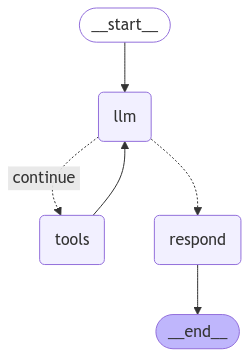

In [31]:
# Define a new graph
workflow = StateGraph(AgentState)

# Add Nodes into Workflow:
workflow.add_node("llm", call_model)
workflow.add_node("tools", tool_node)
workflow.add_node("respond", respond)

# Set the entrypoint:
workflow.set_entry_point("llm")

# This means that this node is the first one called
workflow.add_conditional_edges(
    "llm",
    should_continue,
    {
        "continue": "tools",
        "respond": "respond",
    },
)

# Add Cyclic Node:
workflow.add_edge("tools", "llm")

# Set the exitpoint or end point:
workflow.add_edge("respond", END)

# Compile the Graph:
app = workflow.compile()


app

#### **Invoking:**

In [34]:
answer = app.invoke(input={"messages": [("human", "Tell me about LLM?")]})
answer

{'messages': [HumanMessage(content='Tell me about LLM?', additional_kwargs={}, response_metadata={}, id='0ae9e780-afb2-4349-a32b-6e65a12b9e6f'),
  AIMessage(content='', additional_kwargs={'tool_calls': [{'id': 'call_f5p3', 'function': {'arguments': '{"prompt":"Tell me about LLMs"}', 'name': 'get_city_details'}, 'type': 'function'}]}, response_metadata={'token_usage': {'completion_tokens': 88, 'prompt_tokens': 941, 'total_tokens': 1029, 'completion_time': 0.16, 'prompt_time': 0.035938659, 'queue_time': 0.019845867000000003, 'total_time': 0.195938659}, 'model_name': 'Gemma2-9b-It', 'system_fingerprint': 'fp_10c08bf97d', 'finish_reason': 'tool_calls', 'logprobs': None}, id='run-265f90ed-72ec-4191-a77b-8965fe99d949-0', tool_calls=[{'name': 'get_city_details', 'args': {'prompt': 'Tell me about LLMs'}, 'id': 'call_f5p3', 'type': 'tool_call'}], usage_metadata={'input_tokens': 941, 'output_tokens': 88, 'total_tokens': 1029}),
  ToolMessage(content='[{"url": "https://www.cloudflare.com/learning

In [37]:
# Definition:
print(answer['final_response'].definition)
print()

# Description:
print(answer['final_response'].description)
print()

# Why required these?
print(answer['final_response'].why)
print()

# Where to use?
print(answer['final_response'].where)
print()

# Example:
print(answer['final_response'].example)
print()

# Advantage:
print(answer['final_response'].advantage)
print()

# Disadvantage:
print(answer['final_response'].disadvantage)

A large language model (LLM) is an advanced artificial intelligence system trained on massive text datasets.

LLMs are capable of understanding and generating human-like text, enabling them to perform a wide range of language-based tasks.

LLMs are important because they enable machines to understand and generate human language, opening up new possibilities for human-computer interaction and automation.

LLMs are used in various applications, including chatbots, virtual assistants, machine translation, text summarization, and content creation.

Generating different creative text formats,  like poems, code, scripts, musical pieces, email, letters, etc. I will try my best to fulfill all your requirements.

LLMs can process longer text sequences and perform complex tasks like summarization and question answering.

LLMs can sometimes generate inaccurate or biased information, as they learn from the data they are trained on.
